In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector

from get_data import *

### Data load

In [2]:
ds, cols_model = get_data_model_v2()

Database object created


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


In [3]:
cols_model.remove('direccion_x')
cols_model.remove('direccion_y')
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']/ds['tamano']

In [4]:
aux = ds[['municipio', 'precio', 'tamano']].copy()
aux['precio_m2'] = aux['precio']/aux['tamano']
df_municipio = aux.groupby('municipio').agg({'precio_m2': 'mean', 'tamano':'count'}).sort_values('precio_m2', ascending=False).reset_index()
df_municipio = df_municipio.rename(columns={'tamano':'n_viviendas'})
df_municipio['precio_m2'] = df_municipio['precio_m2'].round(2)
df_municipio[df_municipio['n_viviendas']>=5]

,municipio,precio_m2,n_viviendas
1,oleiros,10.82,83
2,a coruña,9.98,551
3,sada,8.60,24
4,culleredo,8.52,10
5,cambre,7.27,9
6,arteixo,6.57,26
7,bergondo,6.18,8


### Model: Linear reg

In [79]:
def train_model(x,y, model, n_splits=5, n_repeats=5):
    return_val = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    rkf.get_n_splits(x, y)
    for i, (train_index, val_index) in enumerate(rkf.split(x)):
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = x.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred) 
        return_val.append({'rmse_train': rmse_train, 'rmse_val': rmse_val, 'mae_train': mae_train, 'mae_val': mae_val})
    return return_val

#### Linear reg

Repeated CV

In [42]:
trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=5)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 4.14	 std 0.39
RMSE val:	 mean 4.24	 std 1.28

MAE train:	 mean 2.33	 std 0.14
MAE val:	 mean 2.45	 std 0.23


LeaveOneOut

In [25]:
trainings = train_model(x,y, LinearRegression(), n_splits=len(x), n_repeats=1)
rmse_train = [x['rmse_train'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
errors_val = [x['mae_val'] for x in trainings]
rmse_val = np.sqrt(np.power(errors_val, 2).mean())
mae_val = np.mean(errors_val)

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(errors_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(errors_val):.2f}')

RMSE train:	 mean 4.19	 std 0.02
RMSE val:	 mean 4.37	 std 3.63

MAE train:	 mean 2.33	 std 0.01
MAE val:	 mean 2.43	 std 3.63


#### Variable selection

In [26]:
def get_step_score(current_cols, new_col, x, y, model):
    cols = current_cols + [new_col]
    trainings = train_model(x[cols],y, model)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_train = np.mean(rmse_train)
    rmse_val = [x['rmse_val'] for x in trainings]
    rmse_val = np.mean(rmse_val)
    return rmse_train, rmse_val

current_cols = []
scores_train = []
scores_val = []
cols = []
all_columns = cols_model[:]
all_columns.remove('precio')

for k in range(len(all_columns)-1):
    best_col = None
    best_score_training = 1e20
    best_score_val = 1e20
    best_model = None
    for col in set(all_columns)-set(current_cols):
        score_training, score_val = get_step_score(current_cols, col, x, y, LinearRegression())
        if score_training < best_score_training:
            best_score_training = score_training
            best_score_val = score_val
            best_col = col
    current_cols.append(best_col)
    scores_train.append(best_score_training)
    scores_val.append(best_score_val)
    cols.append(current_cols[:])
    print(f'Best column: {best_col}\t score training:{best_score_training:.2f}\t score_val:{score_val:.2f}')

Best column: n_habitaciones	 score training:4.65	 score_val:4.77
Best column: playa	 score training:4.56	 score_val:4.50
Best column: es_casa	 score training:4.50	 score_val:4.43
Best column: tamano	 score training:4.44	 score_val:4.47
Best column: sin_ascensor	 score training:4.38	 score_val:4.41
Best column: densidad	 score training:4.33	 score_val:4.34
Best column: oleiros	 score training:4.29	 score_val:4.33
Best column: estudiantes	 score training:4.25	 score_val:4.25
Best column: balcon	 score training:4.23	 score_val:4.25
Best column: estrenar	 score training:4.22	 score_val:4.27
Best column: amueblado	 score training:4.21	 score_val:4.25
Best column: vacacional	 score training:4.19	 score_val:4.30
Best column: piscina	 score training:4.17	 score_val:4.24
Best column: vistas	 score training:4.18	 score_val:4.25
Best column: coruna	 score training:4.17	 score_val:4.25
Best column: valoracion	 score training:4.17	 score_val:4.24
Best column: parking	 score training:4.16	 score_val

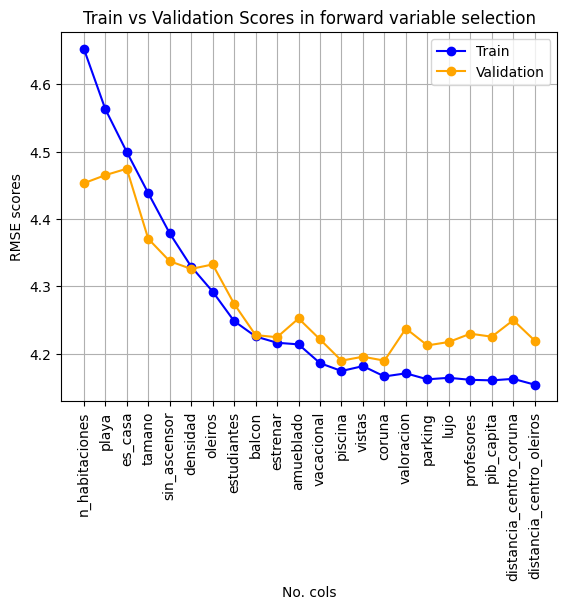

In [27]:
idx = list(range(len(current_cols)))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

### Model: KNN

In [28]:
x_dir = ds[['direccion_x', 'direccion_y', 'tamano', 'precio', 'n_habitaciones']].copy()
x_dir['precio_m2'] = x_dir['precio']/x_dir['tamano']
x_dir = x_dir.dropna().reset_index(drop=True)
y_dir = x_dir['precio_m2']
x_dir = x_dir.drop(['precio', 'precio_m2'], axis=1)

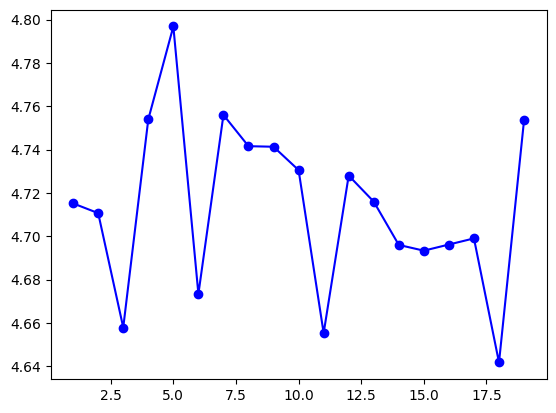

In [29]:
from sklearn.neighbors import KNeighborsRegressor

scores = []
for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors=5)
    trainings = train_model(x_dir,y_dir, knn, n_splits=5, n_repeats=5)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_val = [x['rmse_val'] for x in trainings]
    mae_train = [x['mae_train'] for x in trainings]
    mae_val = [x['mae_val'] for x in trainings]

    # print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
    # print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
    # print("")
    # print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
    # print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')
    scores.append(np.mean(rmse_val))

plt.plot(range(1, 20), scores, marker='o', linestyle='-', color='blue', label='Train')

### Alternativas

##### Regresión lineal

###### Regresión lineal con tamaño

In [9]:
xx = ds[['tamano']]
yy = y

x_reg = xx.values.reshape(-1,1)
y_reg = yy.values.reshape(-1,1)

trainings = train_model(xx,yy, LinearRegression(), n_splits=5, n_repeats=5)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 4.75	 std 0.38
RMSE val:	 mean 4.55	 std 1.48

MAE train:	 mean 2.54	 std 0.11
MAE val:	 mean 2.54	 std 0.29


###### Regresión lineal con tamaño y nº de habitaciones

In [165]:
xx = ds[['tamano', 'n_habitaciones']]
yy = y

x_reg = xx.values.reshape(-1,1)
y_reg = yy.values.reshape(-1,1)

trainings = train_model(xx,yy, LinearRegression(), n_splits=5, n_repeats=5)
rmse_train = [x['rmse_train'] for x in trainings]
rmse_val = [x['rmse_val'] for x in trainings]
mae_train = [x['mae_train'] for x in trainings]
mae_val = [x['mae_val'] for x in trainings]

print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
print("")
print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')

RMSE train:	 mean 4.65	 std 0.40
RMSE val:	 mean 4.47	 std 1.45

MAE train:	 mean 2.50	 std 0.11
MAE val:	 mean 2.51	 std 0.27


##### Regresión con una función no lineal

In [269]:
from scipy.optimize import curve_fit

class model_function():
    def __init__(self, func, initial_params):
        self.initial_params = initial_params
        self.params = initial_params
        self.covariance = None
        self.func = func

    def fit(self, x, y):
        self.params, self.covariance = curve_fit(self.func, x, y, p0=initial_params)

    def predict(self, x):
        return x.apply(lambda x: self.func(x, *self.params))

def plot_scatter_with_fitted_curve(xx, yy, model):
    plt.figure(figsize=(15, 9))
    plt.scatter(xx, yy, label='Original Data', marker='.')
    xx_sorted = pd.Series(np.sort(xx))
    plt.plot(xx_sorted, model.predict(xx_sorted), color='red', marker='.', label='Fitted Curve')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

###### Usando solo el tamano

Training RMSE: 4.514368861212564 0.33894833863250123
Validation RMSE: 4.377312963557942 1.3340843817627488


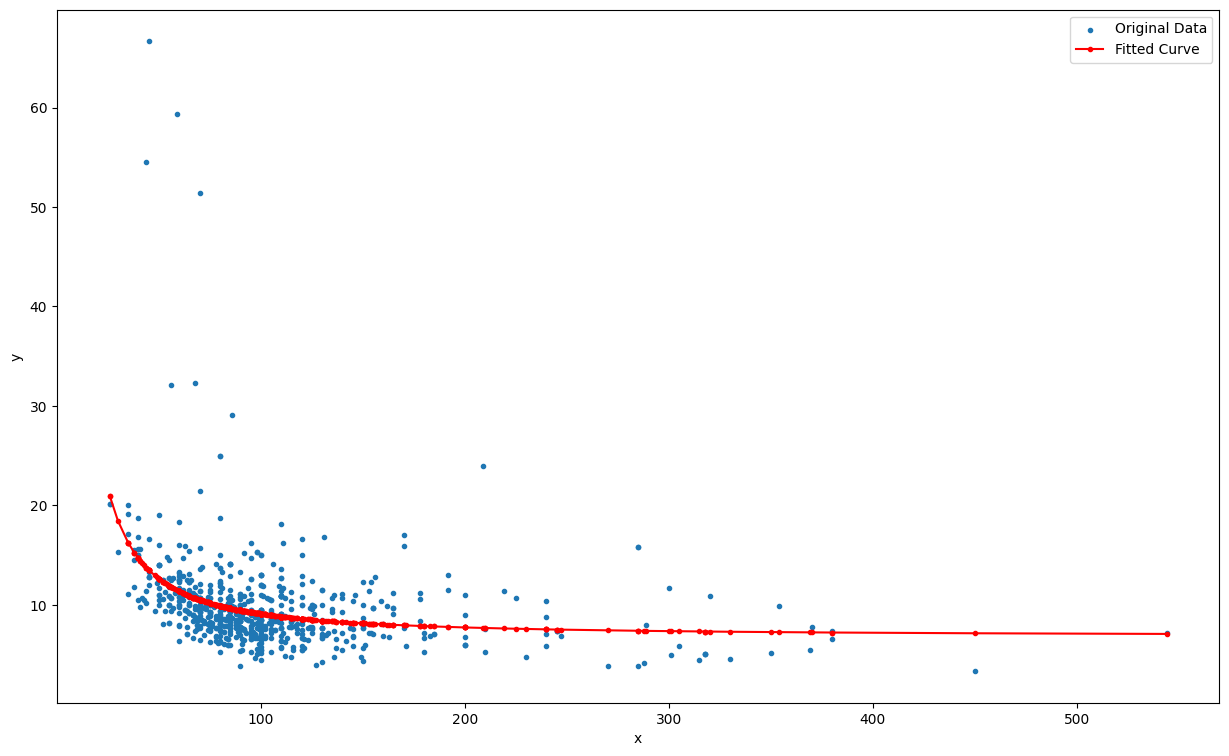

In [280]:
from scipy.optimize import curve_fit

def func(x, *params):
    a, b, c = params
    return a / x**c + b

rmse_train_list = []
rmse_val_list = []

xx = ds['tamano']
yy = y

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(xx, yy, test_size=0.2)  # You can adjust the test_size and random_state

    initial_params = (1.0, 0.1, 4)
    model = model_function(func, initial_params)
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)

print("Training RMSE:", np.mean(rmse_train_list), np.std(rmse_train_list))
print("Validation RMSE:", np.mean(rmse_val_list), np.std(rmse_val_list))

plot_scatter_with_fitted_curve(xx, y, model)

###### Caso multivariable

In [281]:
# Define the function
def func(x, a, b, c, d):
    x1, x2 = x
    return a / x1**c + b + d*x2

rmse_train_list = []
rmse_val_list = []

xx = ds[['tamano', 'n_habitaciones']]
yy = y

for i in range(1000):
    x_train, x_val, y_train, y_val = train_test_split(xx, yy, test_size=0.2)
    # Fit the function to data
    initial_guess = [1.0, 1.0, 0.2, 0.05]  # Initial guess for parameters
    fit_params, _ = curve_fit(func, (x_train['tamano'], x_train['n_habitaciones']), y_train, p0=initial_guess)

    y_train_pred = func((x_train['tamano'], x_train['n_habitaciones']), *fit_params)
    y_val_pred = func((x_val['tamano'], x_val['n_habitaciones']), *fit_params)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)

print("Training RMSE: Mean {:.2f}, Std {:.2f}".format(np.mean(rmse_train_list), np.std(rmse_train_list)))
print("Validation RMSE: Mean {:.2f}, Std {:.2f}".format(np.mean(rmse_val_list), np.std(rmse_val_list)))

Training RMSE: Mean 4.50, Std 0.35
Validation RMSE: Mean 4.39, Std 1.30


In [291]:
y_precio = ds['precio']

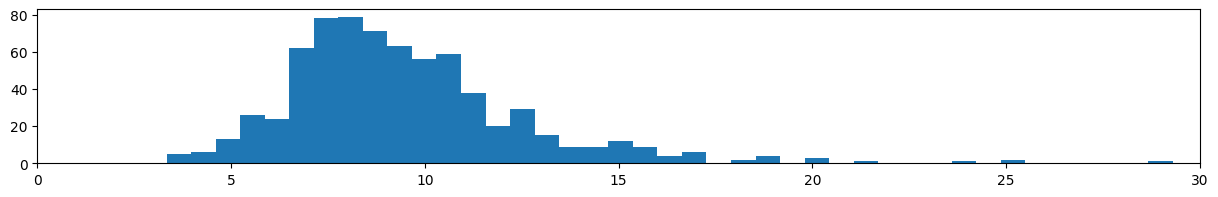

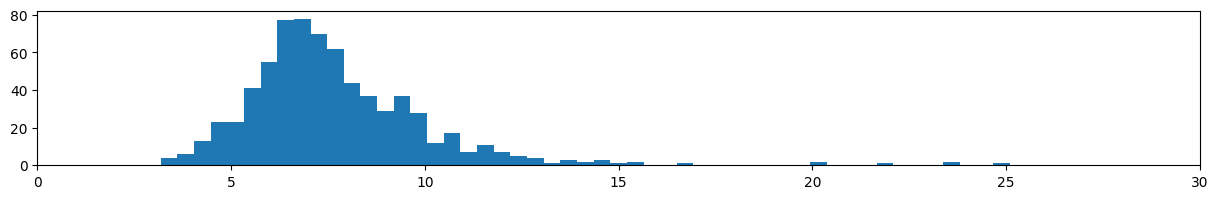

In [311]:
aux = y_precio/(ds['tamano']+0)
plt.figure(figsize=(15, 2))
plt.hist(aux, bins=100)
plt.xlim(0, 30)
plt.show()
aux = y_precio/(ds['tamano']+20)
plt.figure(figsize=(15, 2))
plt.xlim(0, 30)
plt.hist(aux, bins=100)
plt.show()

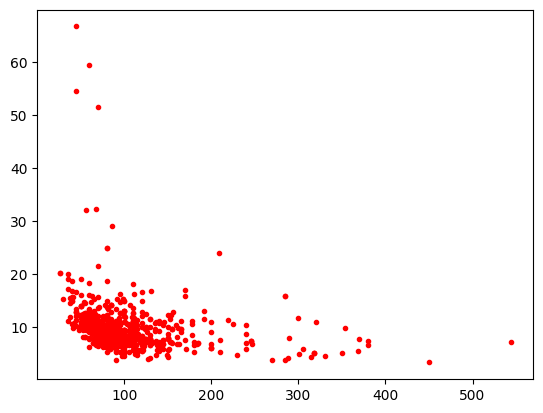

In [288]:
plt.scatter(x['tamano'], y, color='red', marker='.', label='Fitted Curve')